In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import lazypredict
from lazypredict.Supervised import LazyClassifier

In [2]:
data = pd.read_excel("combined_dataset.xlsx")
data.head()

,message,label
0,आप सभी को 78 वें स्वतंत्रता दिवस की हार्दिक शु...,ham
1,"हाल के दिनों में, हमें आईआईटी और एनआईटी के विभ...",ham
2,"हाय छात्र, छात्रवृत्ति परीक्षा के लिए आवेदन कर...",spam
3,"हाँ, मैंने भी इसे गेट के पास देखा था",ham
4,हर दिन कुछ नया करने की कोशिश करें। यह आपको ऊर्...,ham


In [3]:
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071 entries, 0 to 2070
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  2071 non-null   object
 1   label    2071 non-null   object
dtypes: object(2)
memory usage: 32.5+ KB
None
                                                  message label
count                                                2071  2071
unique                                               1849     4
top     विजेता बनें और 10,000 रुपये जीतें! जल्द से जल्...   ham
freq                                                   11  1076


In [4]:
data['label'] = data['label'].apply(lambda x : x.lower())
count = data.label.value_counts()
count

label
ham     1306
spam     765
Name: count, dtype: int64

In [5]:
#1. Converting english text in messages to lower case
data['low_msg'] = data['message'].apply(lambda x : x.lower())

#2. Removing new line chars and spaces.
def rem_char(text):
    return re.sub(r'\n+', ' ', text)
data['clean_text'] = data['low_msg'].apply(lambda x : rem_char(x))

## Feature extraction

In [6]:
#1. Label encoding
def enc(text):
    if (text == 'ham'):
        return 0 
    else:
        return 1

data['labels'] = data['label'].apply(lambda x: enc(x))
#2. Text length
def text_length(text):
    return len(text)

data['text_len'] = data['clean_text'].apply(lambda x: text_length(x))

#3. Word count
def word_count(text):
    return len(text.split())

data['word_count'] = data['clean_text'].apply(lambda x: word_count(x))

#4. Punctuation count
import string
hindi_punc = string.punctuation + '।॥“”‘’'

def pun_count(text):
    return sum(1 for char in text if char in hindi_punc)

data['punc_count'] = data['clean_text'].apply(lambda x: pun_count(x))

In [7]:
#5. Spam Keyword Count

hindi_spam_hype_words = [
    # Promotional Words
    "मुफ्त", "फ्री", "ऑफर", "डिस्काउंट", "कैशबैक", "बोनस", 
    "कूपन", "छूट", "विजेता", "लॉटरी", "इनाम", "जीतो", 
    "सेल", "एक्सक्लूसिव", "तुरंत",
    
    # Urgency Words
    "अभी", "आज ही", "सीमित समय", "जल्दबाज़ी करें", 
    "तुरंत कार्यवाही करें", "जल्द ही समाप्त", "सिर्फ अभी", 
    "अंतिम मौका", "अंतिम अवसर",
    
    # Action Words
    "रजिस्टर करें", "खरीदें", "जॉइन करें", "शुरू करें", 
    "साइन अप करें", "लॉगिन करें", "डिजिटल भुगतान करें", 
    "भुगतान करें", "डिलीवर करें",
    
    # Money-Related Words
    "पैसा", "धनराशि", "ऋण", "ब्याज मुक्त", "अवसर", 
    "इन्वेस्ट करें", "जमा करें", "उधार", "पुरस्कार",
    
    # Suspicious/Scam Words
    "सुरक्षा अलर्ट", "पासवर्ड रीसेट", "खाता बंद", 
    "तुरंत कार्यवाही करें", "भुगतान लंबित", "पुष्टि करें", 
    "मौका पाएं", "सत्यापन करें", "असली विजेता"
]

def hype_word_count(text):
    return sum(word in text for word in hindi_spam_hype_words)
data['spam_word'] = data['clean_text'].apply(lambda x: hype_word_count(x))

In [8]:
#6. Currency symbols
rupee_terms = [
    "रुपया","रुपये","रुपयों","रुपैया","रुपैयों","₹","रुप","पैसा","पैसे","पैसों","नकद","धन","रकम","मूल्य","दाम","कीमत","btc","rs","$","£","usd",r"rs.[\d]*"
]
def currency_count(text):
    return sum(word in text for word in rupee_terms)
data['currency_count'] = data['clean_text'].apply(lambda x: currency_count(x))

#7. Contains phone nos.
def contains_phone_number(text):
    phone_number_pattern = [r"(?:\+91[-\s]?)?[6-9]\d{9}", r"(?:\+91[-\s]?)?[6-9]\d{1,5}x{2,9}"]
    for pattern in phone_number_pattern:
        if re.search(pattern, text):
            return 1
    return 0

data['has_phn_no'] = data['clean_text'].apply(lambda x: contains_phone_number(x))

#8. Has URLS
def contains_url(text):
    url_pattern = r"\b(?:http[s]?://|www\.)?[a-zA-Z0-9-]+\.[a-zA-Z]{2,}(?:\.[a-zA-Z]{2,})?(?:/[^\s]*)?\b"
    return 1 if re.search(url_pattern, text) else 0

data['has_urls'] = data['clean_text'].apply(lambda x: contains_url(x))

#9. English words are present in spam

def contains_english(text):
    english_pattern = r"\b[A-Za-z]+\b"
    return 1 if re.search(english_pattern, text) else 0

data['has_eng_word'] = data['clean_text'].apply(lambda x: contains_english(x))

In [9]:
#10. Has emojis
def emoji_has(text):
    emoji_pattern = re.compile(
        r"([\U0001F600-\U0001F64F]|"  # Emoticons
        r"[\U0001F300-\U0001F5FF]|"  # Symbols & Pictographs
        r"[\U0001F680-\U0001F6FF]|"  # Transport & Map
        r"[\U0001F1E0-\U0001F1FF]|"  # Flags
        r"[\U00002600-\U000026FF]|"  # Miscellaneous Symbols
        r"[\U00002700-\U000027BF]|"  # Dingbats
        r"[\U0001F900-\U0001F9FF]|"  # Supplemental Symbols and Pictographs
        r"[\U0001FA70-\U0001FAFF]|"  # Symbols and Pictographs Extended-A
        r"[\U0001F018-\U0001F270]|"  # Various emoji ranges
        r"[\U0001F680-\U0001F6FF]|"  # Transport and map symbols
        r"[\U0001F300-\U0001F5FF])"  # Other pictographs
    )
    return 1 if emoji_pattern.search(text) else 0

data['has_emoji'] = data['clean_text'].apply(lambda x: emoji_has(x))

## Data

In [10]:
data.describe()

,labels,text_len,word_count,punc_count,spam_word,currency_count,has_phn_no,has_urls,has_eng_word,has_emoji
count,2071.00,2071.00,2071.00,2071.00,2071.00,2071.00,2071.00,2071.00,2071.00,2071.00
mean,0.37,103.68,19.61,4.41,0.51,0.26,0.06,0.16,0.30,0.04
std,0.48,106.40,19.05,5.43,0.97,0.61,0.25,0.37,0.46,0.20
min,0.00,9.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,44.00,9.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,74.00,15.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,1.00,134.00,24.00,6.00,1.00,0.00,0.00,0.00,1.00,0.00
max,1.00,1702.00,338.00,52.00,9.00,5.00,1.00,1.00,1.00,1.00


In [11]:
data

,message,label,low_msg,clean_text,labels,text_len,word_count,punc_count,spam_word,currency_count,has_phn_no,has_urls,has_eng_word,has_emoji
0,आप सभी को 78 वें स्वतंत्रता दिवस की हार्दिक शु...,ham,आप सभी को 78 वें स्वतंत्रता दिवस की हार्दिक शु...,आप सभी को 78 वें स्वतंत्रता दिवस की हार्दिक शु...,0,60,10,4,0,0,0,0,0,1
1,"हाल के दिनों में, हमें आईआईटी और एनआईटी के विभ...",ham,"हाल के दिनों में, हमें आईआईटी और एनआईटी के विभ...","हाल के दिनों में, हमें आईआईटी और एनआईटी के विभ...",0,85,16,2,0,0,0,0,0,0
2,"हाय छात्र, छात्रवृत्ति परीक्षा के लिए आवेदन कर...",spam,"हाय छात्र, छात्रवृत्ति परीक्षा के लिए आवेदन कर...","हाय छात्र, छात्रवृत्ति परीक्षा के लिए आवेदन कर...",1,141,23,9,1,0,0,1,1,0
3,"हाँ, मैंने भी इसे गेट के पास देखा था",ham,"हाँ, मैंने भी इसे गेट के पास देखा था","हाँ, मैंने भी इसे गेट के पास देखा था",0,36,9,1,0,0,0,0,0,0
4,हर दिन कुछ नया करने की कोशिश करें। यह आपको ऊर्...,ham,हर दिन कुछ नया करने की कोशिश करें। यह आपको ऊर्...,हर दिन कुछ नया करने की कोशिश करें। यह आपको ऊर्...,0,58,12,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2066,Airtel के डेटा रोलओवर प्लान्स के बारे में जाने...,spam,airtel के डेटा रोलओवर प्लान्स के बारे में जाने...,airtel के डेटा रोलओवर प्लान्स के बारे में जाने...,1,95,19,1,0,0,0,0,1,0
2067,Jio Fiber के नए प्लान्स और ऑफर्स की जानकारी के...,spam,jio fiber के नए प्लान्स और ऑफर्स की जानकारी के...,jio fiber के नए प्लान्स और ऑफर्स की जानकारी के...,1,76,16,1,1,0,0,0,1,0
2068,अपना Vodafone नंबर ऑफर अलर्ट के लिए पंजीकृत कर...,spam,अपना vodafone नंबर ऑफर अलर्ट के लिए पंजीकृत कर...,अपना vodafone नंबर ऑफर अलर्ट के लिए पंजीकृत कर...,1,75,14,1,2,0,0,0,1,0
2069,BSNL के परिवार प्लान्स की जानकारी के लिए अपने ...,spam,bsnl के परिवार प्लान्स की जानकारी के लिए अपने ...,bsnl के परिवार प्लान्स की जानकारी के लिए अपने ...,1,83,17,1,0,0,0,0,1,0


In [12]:
new_data =data[['clean_text','labels','text_len','word_count','punc_count','spam_word','currency_count','has_phn_no','has_urls','has_eng_word','has_emoji']]

In [13]:
new_data.describe()

,labels,text_len,word_count,punc_count,spam_word,currency_count,has_phn_no,has_urls,has_eng_word,has_emoji
count,2071.00,2071.00,2071.00,2071.00,2071.00,2071.00,2071.00,2071.00,2071.00,2071.00
mean,0.37,103.68,19.61,4.41,0.51,0.26,0.06,0.16,0.30,0.04
std,0.48,106.40,19.05,5.43,0.97,0.61,0.25,0.37,0.46,0.20
min,0.00,9.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,44.00,9.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,74.00,15.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,1.00,134.00,24.00,6.00,1.00,0.00,0.00,0.00,1.00,0.00
max,1.00,1702.00,338.00,52.00,9.00,5.00,1.00,1.00,1.00,1.00


<Axes: >

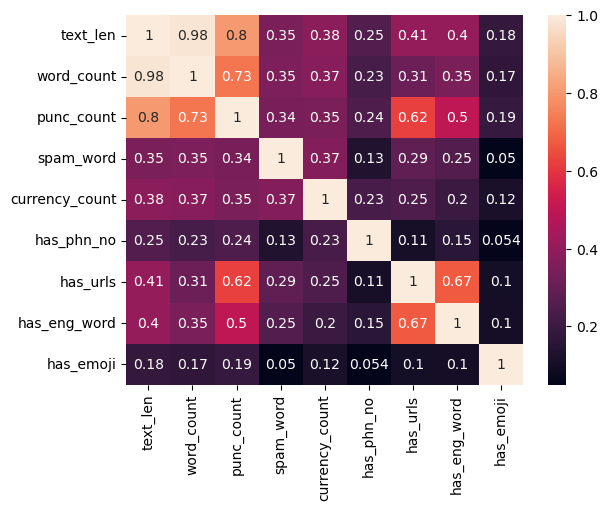

In [14]:
da_cor = ['text_len','word_count','punc_count','spam_word','currency_count','has_phn_no','has_urls','has_eng_word','has_emoji']
corr = new_data[da_cor].corr()
sns.heatmap(corr, annot=True)

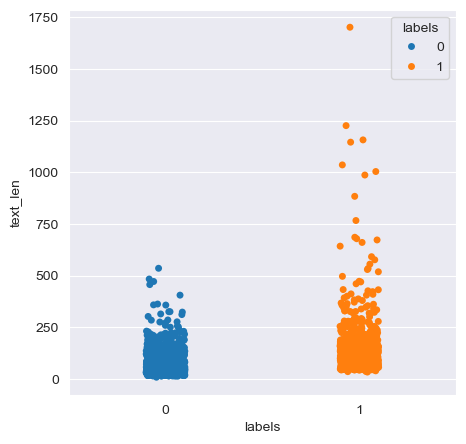

In [15]:
sns.set_style("darkgrid")
plt.figure(figsize=(5,5))
ax = sns.stripplot(y = 'text_len', x = 'labels', data = new_data, hue = 'labels')
plt.show()

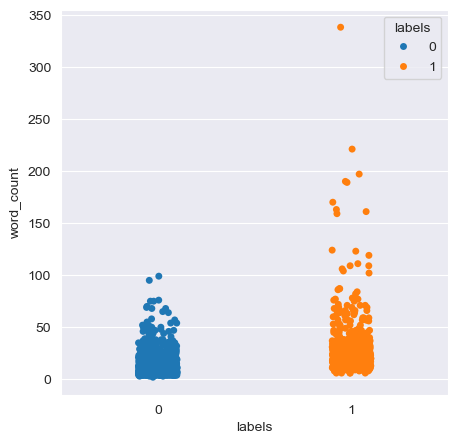

In [17]:
sns.set_style("darkgrid")
plt.figure(figsize=(5,5))
ax = sns.stripplot(y = 'word_count', x = 'labels', data = new_data, hue = 'labels')
plt.show()

## Normalizing textlen, punc, currency, wordcount labels

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0.5,1))
data_norm = data[['text_len','word_count','punc_count']].copy()
new_data[['norm_length','norm_word_cnt','norm_punc_cnt']] = scaler.fit_transform(data_norm)

In [19]:
new_data.describe()

,labels,text_len,word_count,punc_count,spam_word,currency_count,has_phn_no,has_urls,has_eng_word,has_emoji,norm_length,norm_word_cnt,norm_punc_cnt
count,2071.00,2071.00,2071.00,2071.00,2071.00,2071.00,2071.00,2071.00,2071.00,2071.00,2071.00,2071.00,2071.00
mean,0.37,103.68,19.61,4.41,0.51,0.26,0.06,0.16,0.30,0.04,0.53,0.53,0.54
std,0.48,106.40,19.05,5.43,0.97,0.61,0.25,0.37,0.46,0.20,0.03,0.03,0.05
min,0.00,9.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.50,0.50
25%,0.00,44.00,9.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.51,0.51,0.51
50%,0.00,74.00,15.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.52,0.52,0.52
75%,1.00,134.00,24.00,6.00,1.00,0.00,0.00,0.00,1.00,0.00,0.54,0.53,0.56
max,1.00,1702.00,338.00,52.00,9.00,5.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


<Axes: >

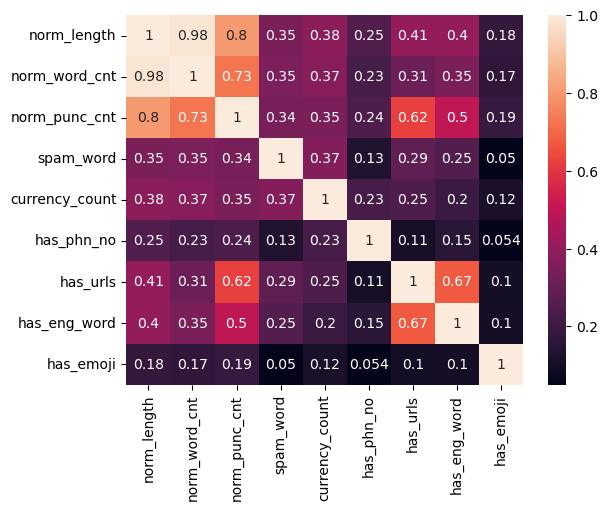

In [33]:
da_corr = ['norm_length','norm_word_cnt','norm_punc_cnt','spam_word','currency_count','has_phn_no','has_urls','has_eng_word','has_emoji']
corre = new_data[da_corr].corr()
sns.heatmap(corre, annot=True)

## Method 1: Vectorizing only the Message feature and training with Label features.

In [20]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(new_data['clean_text'])

y = new_data['labels']
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size = 0.2, random_state = 42)

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [01:46<00:00,  3.45s/it]

[LightGBM] [Info] Number of positive: 620, number of negative: 1036
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4020
[LightGBM] [Info] Number of data points in the train set: 1656, number of used features: 169
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.374396 -> initscore=-0.513403
[LightGBM] [Info] Start training from score -0.513403
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
ExtraTreesClassifier               0.96               0.95     0.95      0.96   
RandomForestClassifier             0.95               0.94     0.94      0.95   
XGBClassifier                      0.94               0.94     0.94      0.94   
LGBMClassifier                     0.93 

## Method 2: Training Extracted features and the labels

In [21]:
#tfidf1 = TfidfVectorizer()
other_features = new_data[['norm_word_cnt','norm_punc_cnt','norm_length','has_emoji','has_eng_word','has_urls','has_phn_no','currency_count']]
#XD = tfidf1.fit_transform(other_features.iloc[0])

yd = new_data['labels']
XD_train, XD_test, yd_train, yd_test = train_test_split(other_features, yd, test_size = 0.2, random_state = 42)

clf1 = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models1,predictions1 = clf1.fit(XD_train, XD_test, yd_train, yd_test)

print(models1)

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:08<00:00,  3.49it/s]

[LightGBM] [Info] Number of positive: 620, number of negative: 1036
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 1656, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.374396 -> initscore=-0.513403
[LightGBM] [Info] Start training from score -0.513403
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
ExtraTreesClassifier               0.93               0.92     0.92      0.93   
RandomForestClassifier             0.92               0.91     0.91      0.92   
KNeighborsClassifier               0.90               0.90     0.90      0.90   
LGBMClassifier                     0.91    

## Method 3: Vectorize message + extracted features and train with labels

In [22]:
tfidf3 = TfidfVectorizer()
other_features3 = new_data[['norm_word_cnt','norm_punc_cnt','norm_length','has_emoji','has_eng_word','has_urls','has_phn_no','currency_count']]
X3 = tfidf3.fit_transform(new_data['clean_text'])

from scipy.sparse import hstack
combined_features = hstack([X3, other_features3])
combined_features_df = pd.DataFrame(combined_features.toarray())
y3 = new_data['labels']
X3_train, X3_test, y3_train, y3_test = train_test_split(combined_features_df, y3, test_size = 0.2, random_state = 42)

clf3 = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models3,predictions3 = clf3.fit(X3_train, X3_test, y3_train, y3_test)

print(models3)

 97%|███████████████████████████████████████████████████████████████████████████████▎  | 30/31 [01:24<00:02,  2.47s/it]

[LightGBM] [Info] Number of positive: 620, number of negative: 1036
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4386
[LightGBM] [Info] Number of data points in the train set: 1656, number of used features: 177
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.374396 -> initscore=-0.513403
[LightGBM] [Info] Start training from score -0.513403


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [01:25<00:00,  2.74s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
RandomForestClassifier             0.97               0.96     0.96      0.97   
ExtraTreesClassifier               0.96               0.96     0.96      0.96   
LGBMClassifier                     0.96               0.95     0.95      0.96   
XGBClassifier                      0.95               0.95     0.95      0.95   
BaggingClassifier                  0.94               0.94     0.94      0.94   
DecisionTreeClassifier             0.93               0.93     0.93      0.93   
NearestCentroid                    0.94               0.92     0.92      0.94   
AdaBoostClassifier                 0.93               0.92     0.92      0.93   
SGDClassifier                      0.93               0.91     0.91      0.93   
Perceptron                         0.92               0.91     0.91      0.92   
PassiveAggressiveClassifier 